<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [898]:
%%capture
pip install pyswarms

In [899]:
%%capture
!pip install numpy==1.26

In [900]:
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [901]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [902]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

In [903]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [904]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [905]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [906]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [907]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [908]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [909]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [910]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [911]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario01.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario02.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario03.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario04.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [912]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [913]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [914]:
# Parâmetros do PSO
num_particles = 50
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

print("")
print("Melhores valores para λ, β, θ :", best_position)

2023-10-21 22:40:17,209 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-2.17e-24
2023-10-21 22:40:17,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.1737393815753107e-24, best pos: [124.35402925   1.99986118   0.29028452]



Melhores valores para λ, β, θ : [124.35402925   1.99986118   0.29028452]


In [915]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 124.35402924904847
beta: 1.9998611795954648
theta: 0.29028451970600777


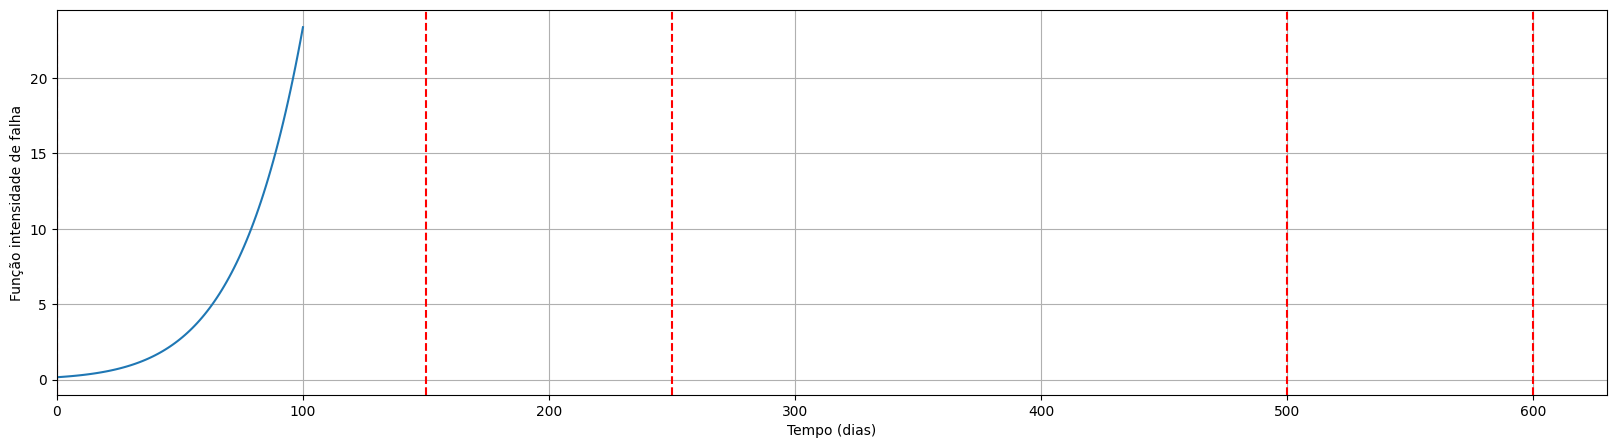

Fator ajuste:  [0.10962611403542033, 0.13510075608083427, 0.22991629922386547, 0.05640374843655738]


In [916]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [917]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [918]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-21 22:40:19,222 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   7%|▋         |7/100, best_cost=2.95e+8



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 60, 107, 129, 217, 258, 292, 358, 362, 417, 458, 498, 601, 651, 675, 703]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 0.0006841220321731773, 0.16163130329032685, 0.8474151869898774, 171.2498200906638, 386.26770100755493, 982.2878686600759, 20224.69901293468, 20880.027421093964, 43858.927298841365, 125276.69504604166, 219081.91645369458, 2089610.0884596705, 4538362.835653679, 8089379.177918918, 13961581.75468979, 10691580.977613948]
Custo =  1847173608

pyswarms.single.global_best:  31%|███       |31/100, best_cost=6.7e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 84, 119, 152, 198, 249, 289, 312, 346, 432, 459, 502]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427]
Media de falhas:  [0, 7.013239824184505e-11, 0.018246482119095072, 0.16171332529186763, 4.0866140988561455, 37.370758450936805, 345.23335023747796, 1435.2732959976072, 2953.9537314164936, 5823.981582016703, 136023.0714220414, 196484.15424484215, 303309.7586085006, 1316454.6922731202]
Custo =  67044046.300226025


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 6, 57, 74, 112, 219, 252, 316, 374, 408, 455, 501, 562, 620, 656]


pyswarms.single.global_best:  40%|████      |40/100, best_cost=6.7e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 89, 200, 282, 304, 332, 373, 428, 454, 502, 536, 542]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427]
Media de falhas:  [0, 3.2759715285650447e-10, 0.03226266474701112, 46.586903379226705, 2150.8709030375367, 3305.8240699621037, 4995.987802109665, 27056.27661353039, 79856.57985124932, 108157.29740514404, 224336.4160649252, 386327.78493247996, 457404.04254095524, 1154222.360307211]
Custo =  135085425.74495268


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 89, 138, 175, 191, 307, 372, 434, 454, 501, 605]
Severidade par

pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=6.7e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 291, 300, 336, 364, 442, 456, 503, 527, 581]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427]
Media de falhas:  [0, 2.9380508665742004e-11, 4817.327274226723, 5073.051313327354, 9241.26996854956, 22870.13068614682, 110922.53891576703, 128108.02588973832, 244575.38951213117, 348069.8173261422, 1250425.8539505345, 2239627.219234868]
Custo =  314276862.2372794


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 232, 290, 301, 337, 372, 441, 455, 503, 535, 608, 643]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sis

pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=6.38e+7<ipython-input-917-3f464f4b430c>:86: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))
pyswarms.single.global_best:  62%|██████▏   |62/100, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 88, 141, 174, 180, 211, 283, 306, 331, 365, 440, 461, 503]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427]
Media de falhas:  [0, 2.9380508665742004e-11, 0.029349873176329182, 0.9808238176576322, 15.320686776521143, 21.433613015353778, 108.7219923848053, 1350.5230072892975, 2033.7998897025223, 4827.299685906693, 20807.646784693585, 103315.9267517301, 130477.93867366956, 237319.2352296031, 1243397.9530245997]
Custo =  63773064.56422952


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 134, 309, 

pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 173, 239, 270, 384, 419, 443, 505, 516, 599]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.07000040649516104]
Media de falhas:  [0, 2.9380508665742004e-11, 26.19151316457848, 172.40689698019955, 1067.2257956595606, 18738.15799318392, 50538.95744633363, 71679.3510991137, 339843.28909367084, 382164.4720740481, 1977359.6942935751, 1993314.7472639706]
Custo =  181295601.0224246


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 96, 168, 230, 240, 298, 418, 444, 453, 505, 523]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fa

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 118, 146, 175, 182, 231, 307, 378, 402, 440, 458, 503, 579]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.5614919185400544, 1.384440497685105, 9.430842114854489, 13.50883501725545, 269.00310742839724, 3031.666484121917, 22113.329130493003, 52583.91172895432, 81354.92467831777, 123641.32880498827, 236315.6745042766, 846105.0407814855, 1415301.4333765064]
Custo =  169280989.6532603


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 146, 177, 299, 30

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=6.38e+7
2023-10-21 22:40:20,771 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134525 4.60326146 2.62958525 5.46974632 1.61268132 1.7765945
 2.58980463 6.51246173 5.65410975 3.65963984 0.85152283 2.44440173
 6.48996846 2.74092506 5.91619819 4.98241273 3.86810918 6.53716244
 2.73864796 1.8407496  2.89944005 5.8066089  4.67976654 5.96187293]
2023-10-21 22:40:20,774 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 94, 172, 237, 266, 284, 442, 455, 503, 583, 629]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427]
Media de falhas:  [0, 2.9380508665742004e-11, 0.05701720324704921, 8.32033409865538, 142.08700549332065, 888.97284550051, 1416.6956382226285, 130199.76853901324, 160109.74345214362, 278446.1099755686, 952404.4717638727, 2625745.212370337, 1543858.9708889269]
Custo =  350987974.07398236


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 84, 98, 172, 230, 281, 443, 458, 503, 520, 613]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,789 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40137687 4.60970826 2.62942759 5.47520725 2.17005459 1.77659439
 2.58974331 5.06437954 5.65374651 3.66486185 0.85235756 2.44449508
 6.49026649 2.74129827 5.91619524 4.9798376  3.86846114 6.53728468
 2.73369509 1.86250544 1.99489814 5.81107754 4.67817369 5.96686556]
2023-10-21 22:40:20,791 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 148, 173, 180, 228, 252, 285, 376, 441, 457, 504, 596, 614]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427]
Media de falhas:  [0, 2.9380508665742004e-11, 5.466667943016709, 9.168646589650063, 12.85505736539457, 236.36533998395456, 452.8140134281841, 1299.1573133714496, 13666.210326838049, 91175.85473575223, 110938.83525330447, 229563.58620884275, 1141227.904794268, 1754004.9287469708, 1281577.2336550413]
Custo =  331303245.931924


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40137247 4.63089566 2.62905175 5.47450049 2.91620515 1.77659431
 2.58970242 4.52884816 5.65394762 3.66290026 0.85303411 2.44446846
 6.48997151 2.73954756 5.91619194 4.98286773 3.86830478 6.53728669
 2.73282195 1.85060106 2.1558615  5.81165501 4.67840515 5.96443675]
2023-10-21 22:40:20,805 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 174, 182, 232, 261, 288, 373, 442, 453, 505, 623]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427]
Media de falhas:  [0, 2.9380508665742004e-11, 27.75109553534571, 30.17518385782498, 298.63940025169126, 640.34679985488, 1453.946187778338, 12405.39221430902, 94450.02400180463, 107436.45804557244, 237775.67359726466, 1869444.2742301193, 1045503.596083928]
Custo =  218819460.37896428


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,819 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40136236 4.64255072 2.6288136  5.47283116 4.16792715 1.77659427
 2.5896766  3.77229084 5.65415417 3.66068447 0.85319526 2.44442668
 6.48970585 2.73806708 5.91618967 4.98550704 3.86810896 6.53726172
 2.73218844 1.83846089 2.460632   5.81082045 4.67865295 5.96199029]
2023-10-21 22:40:20,821 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 138, 174, 214, 269, 291, 379, 444, 505, 585]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 2.7076500135757016, 7.71441540843119, 44.725189729533795, 1198.853664845564, 1970.0271130646825, 14982.190188756846, 97590.39220901972, 244031.79642341498, 939798.6568970808, 1361253.9243388046]
Custo =  162685743.13393408


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,832 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135325 4.65039675 2.62881894 5.47057562 5.822649   1.77659429
 2.58968401 3.1780123  5.65433542 3.65860335 0.85318428 2.44438268
 6.48949035 2.73696314 5.91618958 4.98760579 3.8679328  6.53723375
 2.73199467 1.82771247 2.84227784 5.8100619  4.67907501 5.95976022]
2023-10-21 22:40:20,837 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 12, 174, 293, 446, 506, 716]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 27.660954111105713, 1557.1541325574658, 218753.3892952104, 486177.52561616106, 9377553.915155102, 1185876.6011671992]
Custo =  475391029.7675915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,851 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134421 4.65555581 2.62899311 5.46835563 0.08144029 1.7765943
 2.58972522 2.20312555 5.65448866 3.65681969 0.85311911 2.44434659
 6.48930487 2.73689463 5.91619089 4.98836556 3.86780854 6.53718787
 2.73201305 1.81984272 3.19284908 5.80845379 4.67945767 5.95833784]
2023-10-21 22:40:20,853 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 66, 90, 120, 174, 295, 418, 448, 506, 590, 659, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.001600541658176969, 0.00978207916588477, 0.24113483212487982, 6.912682771032514, 3693.4361706069812, 111824.96978611016, 164372.42689065993, 425910.3164903744, 1205078.7830972057, 4659844.668332058, 7811850.96069482, 4010791.4870798434]
Custo =  639703874.4356133


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,865 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133635 4.64543633 2.62920062 5.46668043 2.12222592 1.77659433
 2.58976936 1.44988994 5.65460111 3.65590199 0.85270391 2.4443142
 6.48925743 2.73722855 5.91619208 4.98829044 3.86773059 6.53714046
 2.73207115 1.81717226 3.50065287 5.80660065 4.67982909 5.95723699]
2023-10-21 22:40:20,866 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 69, 104, 174, 295, 399, 506, 626, 657, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.0025076160977940748, 0.04388172521847122, 12.397050062878854, 1664.4601061195185, 66854.83107364576, 442787.6587443227, 3436179.1827322296, 5257929.612962175, 11121339.425453573, 7382187.429365376]
Custo =  920533453.0780787


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133138 4.63475975 2.62947316 5.46556124 4.59913534 1.77659438
 2.58981659 1.04759031 5.65461979 3.65573489 0.8522013  2.44428875
 6.48925634 2.73807479 5.91619436 4.98669281 3.86772055 6.53710436
 2.73378416 1.81992135 3.76046758 5.80493462 4.68014944 5.95637096]
2023-10-21 22:40:20,879 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 70, 118, 129, 174, 294, 506, 523, 585, 615, 655, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.0028997512138184576, 0.17492349077698272, 0.42214389248272777, 6.260096110899429, 1595.9775377567246, 819622.8250363587, 954691.8262211188, 2013325.6793766194, 2527520.58651334, 4708369.474469155, 10893305.629994247, 7092246.156379271]
Custo =  971998737.3338355


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,893 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40132713 4.62190729 2.62974275 5.46567736 0.44326826 1.77659443
 2.58985719 0.08485285 5.65456187 3.65639876 0.8516927  2.4442846
 6.48944132 2.73912409 5.91619754 4.98434903 3.86772691 6.53708455
 2.73575407 1.8285145  3.88308936 5.80376426 4.68042163 5.95657398]
2023-10-21 22:40:20,894 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 71, 173, 268, 292, 359, 368, 506, 601, 652, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.0033462369492251484, 11.759535126051775, 872.8633930894049, 2449.092735703942, 8973.319591242529, 12086.30144762443, 724358.9119450487, 3906136.0813737893, 6426979.147162147, 12849862.119561564, 9048802.645946588]
Custo =  918347160.2130678


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40132648 4.6077546  2.62995167 5.46645857 3.82627358 1.77659449
 2.58988466 0.10879797 5.654449   3.65727599 0.85122019 2.4442919
 6.48968646 2.74043655 5.91620045 4.98173607 3.86775689 6.53706829
 2.73824725 1.8390257  3.9345065  5.80281309 4.68057202 5.95691382]
2023-10-21 22:40:20,909 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 68, 138, 173, 262, 290, 366, 410, 506, 650, 714]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.0021638690236122165, 1.0297501768691864, 9.047307813098808, 679.4104673541575, 2319.7760660448253, 10825.689852527576, 41361.77734856727, 395783.0721772085, 8477802.260579012, 15385236.033229977, 11458093.350776384]
Custo =  812268075.9822235


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,921 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40132748 4.5943612  2.63003092 5.4674299  6.95873153 1.77659455
 2.58989175 0.09205248 5.65432019 3.65846336 0.85087248 2.44429884
 6.48993976 2.74174478 5.91620248 4.97943017 3.86785398 6.53705627
 2.74049608 1.84864754 3.76410837 5.80212296 4.68064628 5.95838401]
2023-10-21 22:40:20,922 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 65, 172, 235, 256, 288, 367, 398, 506, 649, 715]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.0013717453349761436, 11.88689863396101, 210.87609884231642, 633.1933409893322, 1547.6108083427416, 10504.786729060826, 28562.90649590646, 249574.03536439806, 8191338.803804867, 15344526.721107667, 11353190.982739357]
Custo =  805682172.2258104


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,934 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40132909 4.58391609 2.62999117 5.46840312 2.50164002 1.77659459
 2.58987473 6.38693249 5.65418212 3.65982394 0.8506406  2.44433482
 6.49017407 2.74275902 5.91620412 4.97739507 3.86794356 6.53707465
 2.74214387 1.85602584 3.43901103 5.80184369 4.68070181 5.95993296]
2023-10-21 22:40:20,936 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 60, 172, 210, 251, 287, 400, 449, 506, 580, 648, 717]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.0006107548413306822, 12.636633518144361, 65.0033910148003, 587.2831520462234, 2322.692616748598, 27945.635019768357, 104561.43831602114, 577088.5594849028, 1185148.7199468813, 4109171.7751196804, 8232799.522703452, 4110730.8185154754]
Custo =  625418980.1423147


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,950 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133077 4.57543033 2.62989925 5.46958068 5.33430321 1.77659463
 2.58984999 5.06640457 5.65404084 3.66104703 0.8505757  2.44437551
 6.49033579 2.74346228 5.91620406 4.97623961 3.86803411 6.53709683
 2.74269336 1.85865632 3.04428954 5.80247757 4.68049246 5.96167022]
2023-10-21 22:40:20,951 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 172, 248, 285, 367, 408, 447, 452, 505, 523, 575, 648, 719]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 24.630057818228273, 253.1746947514002, 1903.1838138015466, 11090.620158077061, 38891.83023488084, 101568.9690675859, 123685.13465180606, 255876.3623763556, 330872.3305973018, 1128569.050984386, 2813305.538385652, 10744079.390980292, 6488088.972745782]
Custo =  797658740.4944907


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,963 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013324  4.5679816  2.62980959 5.47067116 1.33306232 1.77659464
 2.58982587 3.55748836 5.65392864 3.66208777 0.85058932 2.44441289
 6.49038875 2.7437569  5.91620372 4.97598486 3.86811681 6.53713106
 2.74229782 1.85767291 2.65463371 5.80348881 4.68010321 5.96323405]
2023-10-21 22:40:20,965 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 115, 172, 238, 245, 285, 416, 446, 453, 505, 649]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.43342180514835216, 6.687996992345339, 147.32590863497515, 263.8491922590082, 1985.8078897715536, 43125.49329142121, 93548.72129579607, 124570.77577650253, 254909.99132819474, 2988549.843123609, 887926.2451951448]
Custo =  283399060.73771673


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133444 4.56514937 2.62967922 5.47145546 4.75003855 1.77659464
 2.58980035 2.03555214 5.65387677 3.66252596 0.8506815  2.44444466
 6.49038074 2.74340692 5.91620323 4.97758612 3.86819001 6.53716712
 2.74188187 1.85200543 2.3307349  5.80476547 4.67973889 5.96457119]
2023-10-21 22:40:20,978 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 102, 131, 172, 244, 285, 445, 454, 505, 651]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.12970804831347751, 0.4364787169544252, 5.3494248605468675, 310.15022332138415, 2054.8118004715043, 91810.4066787047, 112767.4329770566, 241237.7095390244, 3080986.1817366797, 863352.5540896789]
Custo =  273558280.10596424


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 91, 172, 247, 286, 380, 444, 454, 505, 591, 654]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.04113388667722341, 8.62783052265322, 226.59929343060932, 1982.4298664123994, 15940.24921506581, 97777.0353399618, 109907.17416156072, 238377.4507235285, 1042957.516953599, 4065113.0851416443, 1666245.2080004606]
Custo =  427831316.1927469


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:20,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133686 4.56922871 2.62954285 5.47215241 1.03103302 1.77659462
 2.58977797 0.58570302 5.65387179 3.66214327 0.85089416 2.44446213
 6.49030825 2.74269703 5.91620174 4.97991677 3.86824481 6.53719903
 2.74105686 1.84554711 2.12644342 5.80608946 4.67941855 5.96564863]
2023-10-21 22:40:20,993 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 172, 229, 250, 286, 376, 444, 453, 505, 573, 602, 656]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 24.711260549863905, 113.29811156305763, 451.979386358086, 2131.208065887593, 14404.011210066123, 99272.78247082086, 138448.01765281396, 268787.23320450616, 780156.3535345197, 1553444.720683557, 6718152.698192086, 4194537.058326349]
Custo =  732806797.3682895


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013411  4.57401078 2.62942469 5.47213423 4.73219876 1.77659457
 2.58976519 6.92505633 5.65388852 3.66171921 0.85116959 2.44447056
 6.49019668 2.74176283 5.91620015 4.98214646 3.86828785 6.53722288
 2.73997974 1.83934431 2.15134318 5.80741148 4.67914761 5.96623387]
2023-10-21 22:40:21,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 173, 229, 254, 287, 391, 444, 452, 505, 595, 608, 657]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 26.19151316457848, 113.69287993892122, 555.0154059061498, 1051.951773741239, 20592.714417365427, 93278.48897811293, 111321.58373436569, 243512.81145891524, 1127566.5605896707, 1544527.5365906134, 2957481.3169237776, 370284.8619713476]
Custo =  489865282.41977906



2023-10-21 22:40:21,018 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134589 4.58323254 2.62935953 5.47158102 1.65720552 1.77659451
 2.58975834 5.60244418 5.65396759 3.66133569 0.85152239 2.4444673
 6.49004986 2.74087657 5.91619815 4.98418826 3.86830536 6.53724047
 2.73878649 1.83392634 2.29053417 5.80838764 4.67908489 5.96638286]
2023-10-21 22:40:21,019 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 173, 259, 288, 396, 444, 450, 505, 533, 612, 659]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 26.19151316457848, 401.5653552388063, 1974.3590336241878, 24563.872880450268, 92630.43101892437, 105844.79070338517, 241690.74263103315, 372616.0591396205, 2264279.0760851605, 7143945.1623259755, 4427123.062069172]
Custo =  739403180.1845417


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135008 4.59200119 2.62933976 5.47075165 5.88651043 1.77659445
 2.58976087 3.88864125 5.65404034 3.66072235 0.85183995 2.44445039
 6.48990044 2.74009026 5.91619635 4.98583177 3.86832108 6.53723659
 2.73769989 1.82956104 2.42652226 5.80918341 4.67914192 5.96625874]
2023-10-21 22:40:21,033 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,045 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135342 4.60207086 2.62936897 5.46991323 2.29244056 1.77659442
 2.58977056 1.78928426 5.6541134  3.66009403 0.85204704 2.44443403
 6.48977441 2.73940054 5.91619489 4.98635644 3.86833369 6.53721307
 2.73697746 1.8265



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 174, 263, 289, 400, 445, 506, 611, 659, 719]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 27.75109553534571, 471.9709273868083, 1984.230135973391, 27276.664192250068, 93791.76786605174, 364107.0912385638, 1621818.464782363, 4280010.923495806, 11312478.62314462, 7056488.204910109]
Custo =  906123470.1820608


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,060 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135476 4.61118467 2.62940302 5.46915185 5.90761952 1.77659439
 2.58978736 6.32500876 5.65417902 3.6595228  0.85220101 2.44441411
 6.48971604 2.73891945 5.91619409 4.98605045 3.86832051 6.53718617
 2.73664192 1.82455774 2.81583519 5.80929907 4.67933305 5.965319  ]
2023-10-21 22:40:21,061 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 92, 174, 266, 290, 380, 402, 446, 506, 592, 609, 658, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.045635574162951914, 9.691675908657881, 516.1203640904396, 1994.712987616789, 15537.997776285445, 30685.922032824266, 153784.01141182554, 421208.14773277624, 1238547.0159179596, 1778947.9247651927, 4441415.362387041, 11210671.581389097, 7088602.877201121]
Custo =  1015017916.7434901


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135566 4.61935186 2.62945174 5.46856375 1.73024398 1.77659439
 2.5898054  3.41974709 5.65423297 3.65902674 0.85227342 2.44439442
 6.48973561 2.73850437 5.91619396 4.98500988 3.868305   6.53715651
 2.73647975 1.82294318 3.02711457 5.8091151  4.67948704 5.96420341]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 102, 147, 174, 269, 290, 379, 403, 447, 506, 604, 657, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.12898825573908732, 1.3520017865506937, 5.471046962093831, 581.7865819763492, 1926.3672123709368, 15040.063513327412, 31663.484012633908, 68875.19194567876, 333373.7440352666, 1411222.1539373281, 4195219.147290878, 11048477.883814812, 6926409.1796268355]
Custo =  876874971.0329689


2023-10-21 22:40:21,075 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135517 4.62504205 2.62953128 5.46829714 4.96276899 1.77659438
 2.58982142 0.63093217 5.65427514 3.65858142 0.85223998 2.44437863
 6.48979513 2.7388285  5.91619389 4.98342469 3.86824241 6.53713095
 2.736685   1.82269388 3.20605963 5.80845886 4.67967191 5.96310142]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 111, 174, 291, 402, 448, 506, 530, 570, 655, 716]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.30206764207930775, 7.849147710498886, 1423.0019544635998, 73084.62350794868, 144972.8917361064, 406510.7813358209, 515514.44386237155, 1121083.2434396727, 3197274.530012438, 6902784.049700085, 2846475.9294819413]
Custo =  586206311.5273603


2023-10-21 22:40:21,091 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135268 4.62446276 2.62961018 5.46844031 1.27543665 1.77659441
 2.58983476 6.05651256 5.65430175 3.65818875 0.85199871 2.4443676
 6.48986983 2.73950432 5.91619417 4.98182492 3.86815016 6.53710844
 2.73734298 1.82576566 3.30603406 5.80765813 4.67983926 5.96182996]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 117, 144, 174, 291, 401, 448, 506, 533, 654, 716]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.5129596903715657, 1.2190338750611889, 5.6449811654943005, 1420.797787918595, 71165.07733732669, 144118.29171631834, 405656.18131603283, 532610.9643036302, 5079084.806862678, 17910226.573929965, 13853918.453711823]
Custo =  1163626478.4280207


2023-10-21 22:40:21,106 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40135029 4.62095045 2.62967665 5.46891073 5.05342816 1.77659446
 2.58984519 3.94795422 5.65427547 3.65824563 0.85168066 2.44436664
 6.48993755 2.74045843 5.91619515 4.98053831 3.86806508 6.53709747
 2.73819304 1.83140608 3.39323947 5.80671416 4.67996871 5.96069001]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 174, 221, 291, 376, 395, 449, 506, 521, 652, 717]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 27.660954111105713, 83.38175444374977, 2781.354554511526, 36964.576937939535, 48391.707790102046, 130086.68430644242, 388628.1414559914, 450083.94140636723, 5063598.775730881, 9004737.558486547, 4882668.854298571]
Custo =  569087243.0851626


2023-10-21 22:40:21,118 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,131 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013479  4.61655373 2.62971416 5.46957544 1.92896515 1.77659451
 2.58985276 1.40616901 5.65423354 3.65848646 0.85136733 2.44437493
 6.49000013 2.74141059 5.91619629 4.97973254 3.86799851 6.53709691
 2.73901402 1.83652272 3.38615897 5.80584121 4.68004545 5.95992035]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 143, 173, 233, 290, 506, 534, 578, 651, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 3.855816211292013, 8.050261214553293, 115.92534621968379, 2523.257106873986, 380446.6737686224, 630626.2192784147, 1371164.6894730101, 7225173.124594875, 14741833.057438338, 10553206.604120418]
Custo =  1021749591.0675017


2023-10-21 22:40:21,133 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 12, 118, 173, 266, 290, 505, 514, 651, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.5587998258096486, 6.974555419797159, 517.9008783266626, 1996.4935018530118, 371580.29174448014, 436167.9768804723, 5094350.904681513, 9279196.445890252, 5023206.027655741]
Custo =  561084698.2142981



2023-10-21 22:40:21,148 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134515 4.61216383 2.62974216 5.47021099 6.08745625 1.77659455
 2.58985494 6.84135069 5.65416096 3.65895419 0.85108947 2.4443879
 6.49005413 2.74217611 5.91619768 4.97928066 3.86794108 6.53710724
 2.73969716 1.84172791 3.33758039 5.80520142 4.68007711 5.95978598]
2023-10-21 22:40:21,150 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 12, 111, 172, 261, 289, 505, 523, 650, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.30206764207930775, 6.9100860577615455, 421.0226127563728, 2009.2674467969055, 373229.83014138375, 515270.64338544273, 4921661.779473278, 19251868.909891907, 14995878.491657397]
Custo =  1151265877.828823



2023-10-21 22:40:21,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134269 4.60646897 2.62974813 5.47073208 3.38065107 1.77659458
 2.58985548 4.72583698 5.65408363 3.65945655 0.85093803 2.44440356
 6.49008717 2.74266471 5.91619898 4.97959858 3.86790348 6.53712294
 2.74029893 1.84612137 3.18363927 5.80501313 4.68008299 5.96017684]
2023-10-21 22:40:21,163 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 123, 172, 230, 256, 289, 450, 505, 650]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 0.27484147327961744, 5.849724688602557, 161.27234304555532, 648.3094818068657, 1178.3025389092154, 101130.07790490723, 348953.719522174, 3135214.7894840366, 976461.1521853921]
Custo =  270222006.2041688



2023-10-21 22:40:21,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134116 4.60084911 2.62971039 5.47093354 0.44680465 1.7765946
 2.58984227 2.64854996 5.65401759 3.65995606 0.85090358 2.4444176
 6.49008461 2.74278359 5.91620014 4.98025087 3.86790433 6.53714821
 2.74066439 1.85004084 2.98542078 5.80528786 4.68007667 5.9607997 ]
2023-10-21 22:40:21,177 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 96, 172, 221, 252, 288, 449, 451, 505, 651]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.07047489509092092, 8.123919295731646, 65.44675526236699, 532.9303325463011, 1520.5640511900276, 99455.0324139877, 104100.72405200786, 238127.40857467882, 3077875.880772334, 860242.2531253332]
Custo =  273568815.4457556



2023-10-21 22:40:21,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134006 4.59630474 2.6296682  5.47089548 5.15519116 1.77659462
 2.58982962 1.15085595 5.65397264 3.66031925 0.8508796  2.44443011
 6.49007588 2.74252915 5.91620102 4.98102812 3.86794746 6.53717477
 2.74067828 1.85100376 2.79626467 5.80562052 4.68001152 5.96160416]
2023-10-21 22:40:21,190 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 90, 143, 171, 222, 250, 288, 447, 451, 505, 584, 652]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.03680298098304136, 1.119003060209538, 4.710205332017485, 181.8352563268154, 590.1677238632897, 2438.9344897295914, 95473.1602623089, 104611.15950026152, 238637.84402293246, 917411.4331137583, 4013991.605101674, 1736718.6296867006]
Custo =  413373787.408743



2023-10-21 22:40:21,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133917 4.59315591 2.62962636 5.47067893 2.67750756 1.7765946
 2.58981105 6.93385722 5.65396804 3.66058577 0.85085944 2.44443422
 6.49004763 2.741888   5.91620152 4.98183411 3.86800231 6.5371978
 2.74048811 1.85037162 2.62700351 5.80596285 4.67990249 5.96238065]
2023-10-21 22:40:21,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 11, 172, 249, 289, 446, 451, 505, 654, 719]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 24.711260549863905, 264.2824234992442, 2228.9932326494063, 92421.96060251485, 103750.33361236085, 237777.0181350318, 3243312.115872209, 10695312.838809334, 6439322.420574823]
Custo =  703830782.5428904



2023-10-21 22:40:21,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133861 4.59284584 2.62957743 5.47047988 0.20773949 1.77659458
 2.58979432 5.12182436 5.65399887 3.66056659 0.85093016 2.44443223
 6.49001056 2.74125077 5.91620134 4.98261284 3.86806235 6.53721077
 2.74014182 1.84791211 2.50341688 5.80627907 4.67979785 5.96298728]
2023-10-21 22:40:21,218 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 172, 251, 289, 375, 445, 450, 506, 577, 601, 655, 719]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 24.711260549863905, 287.7648877559082, 2198.0505222651914, 13801.399389055352, 101982.13122529077, 107786.44001546585, 247982.99146442523, 810621.0069928216, 1459509.135300132, 2942356.895984459, 10311991.818130797, 6056001.399896286]
Custo =  873803075.9953861



2023-10-21 22:40:21,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133923 4.59491238 2.62953437 5.47028689 5.38509914 1.77659455
 2.58977933 3.03988217 5.65403371 3.66041952 0.85116103 2.44442768
 6.48996467 2.74066914 5.91620102 4.98326051 3.86811697 6.5372093
 2.73951119 1.84488359 2.42240311 5.80660536 4.67969706 5.96348767]
2023-10-21 22:40:21,232 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 93, 172, 224, 254, 289, 361, 445, 506, 605, 656, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.05119762529408193, 8.421146836884796, 76.11286669782875, 570.1604577084216, 2393.0369438333228, 9606.475292566, 107428.97704783251, 377744.3004203446, 1479941.4108853498, 4147552.6712358748, 11434061.42795856, 7178071.009724049]
Custo =  882518442.8868712



2023-10-21 22:40:21,244 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40133986 4.59687227 2.62951087 5.47010821 3.14276605 1.77659452
 2.5897715  0.84134324 5.65408028 3.66011177 0.85144106 2.4444224
 6.48992381 2.74014862 5.91620038 4.98370535 3.86816458 6.5372018
 2.73873671 1.8415144  2.39107885 5.80689924 4.67960782 5.9638374 ]
2023-10-21 22:40:21,246 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 100, 120, 173, 259, 290, 360, 444, 506, 511, 606, 657, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.10627707811068604, 0.21157845206972714, 6.44782937165563, 944.4121953898357, 2694.6592322016613, 9591.394481997213, 105356.73869827969, 602018.9161573963, 620320.999157993, 2550210.798416328, 4008577.1925434098, 11035263.601103304, 6846637.147785384]
Custo =  850307197.7662927



2023-10-21 22:40:21,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134121 4.59989274 2.62950429 5.46986356 0.72492299 1.77659449
 2.58976769 5.77378962 5.65412241 3.65980593 0.85170431 2.44441621
 6.48989507 2.73990884 5.9161997  4.98399524 3.86820715 6.53719009
 2.73801595 1.83829616 2.44745539 5.80708139 4.67957194 5.96376179]
2023-10-21 22:40:21,259 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 106, 128, 173, 237, 262, 290, 444, 506, 592, 606, 656, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1899722015273487, 0.39498624789802095, 5.928487134816926, 138.21263086515103, 727.9471632344245, 1618.0970641980462, 86806.7592039013, 359979.54304581264, 1177318.4112309958, 1610505.197002407, 4238813.993586761, 11349056.97193091, 7160430.51861299]
Custo =  992831088.2659318



2023-10-21 22:40:21,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134351 4.60306622 2.62950789 5.4696125  5.8089844  1.77659446
 2.58976991 3.2318845  5.6541577  3.65950495 0.85191686 2.44441056
 6.48987745 2.73985653 5.91619895 4.98410848 3.86823206 6.53717144
 2.73749844 1.83548768 2.56148194 5.80721592 4.67957396 5.96362482]
2023-10-21 22:40:21,275 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 111, 173, 220, 265, 290, 445, 506, 603, 655, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.30206764207930775, 7.365656015662191, 60.780226706869605, 976.2719559416895, 2497.0462493519804, 89925.13399746093, 360240.457369973, 1414170.2227307367, 4082729.734077333, 11275758.349670714, 7087131.896352794]
Custo =  867736041.7119068



2023-10-21 22:40:21,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134561 4.60593752 2.62952313 5.46940371 3.66870339 1.77659444
 2.58977767 0.63163651 5.65418043 3.65926345 0.85205232 2.44440371
 6.48987442 2.74009345 5.91619824 4.9837056  3.86822776 6.53715295
 2.73732822 1.83415713 2.72124954 5.80728166 4.67962546 5.96322219]
2023-10-21 22:40:21,289 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 114, 174, 220, 267, 290, 446, 506, 537, 579, 601, 654, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.39501715484874644, 7.643724210904667, 60.28478194796193, 1063.901926436267, 1480.5488821584522, 91200.57447780602, 358624.7107987567, 511317.67931859987, 1237755.121048225, 1555841.3563557416, 2996799.542961249, 10097416.489825029, 5975347.785637053]
Custo =  867525400.4505388



2023-10-21 22:40:21,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134743 4.6080707  2.62955455 5.46930648 1.13809739 1.77659443
 2.58978616 5.46799324 5.65418826 3.65907223 0.85207707 2.44439737
 6.48989338 2.74047883 5.91619759 4.98305981 3.86819155 6.53713728
 2.73741401 1.83362819 2.88627673 5.8072479  4.67970345 5.96268697]
2023-10-21 22:40:21,302 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 114, 139, 174, 267, 290, 391, 447, 506, 653, 717]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.39501715484874644, 0.8771465218881318, 5.789386823405603, 534.6210729569689, 1969.812781269974, 21109.084196923992, 101320.21725817412, 365818.7693477619, 3301549.1860933644, 10483102.364609385, 6361033.660421409]
Custo =  694351227.1534265



2023-10-21 22:40:21,316 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134862 4.60932302 2.62958794 5.4692536  5.9978014  1.77659443
 2.5897976  3.06682403 5.65419484 3.65891252 0.85208272 2.44439199
 6.48992213 2.74093542 5.91619704 4.98239329 3.86813914 6.53712879
 2.73757469 1.8338092  3.03755347 5.80716009 4.67978947 5.96204471]
2023-10-21 22:40:21,318 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 113, 136, 174, 267, 290, 379, 391, 448, 506, 652, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.3615138950226361, 0.7332927686157162, 5.927197314355552, 827.2352147612851, 2262.4269230742902, 15376.123224030765, 22378.99176902777, 68263.68834901105, 329801.57794872555, 3210449.572351679, 10647308.81226704, 6458682.358949121]
Custo =  696096793.3487136



2023-10-21 22:40:21,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134907 4.60951167 2.62961757 5.46923082 3.11895448 1.77659444
 2.58980851 0.58291139 5.65419539 3.65894144 0.85207811 2.44438802
 6.48995362 2.74134327 5.91619687 4.98179735 3.86809034 6.53712578
 2.73774036 1.83473579 3.16399054 5.80699128 4.67986308 5.96144583]
2023-10-21 22:40:21,331 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134843 4.6095807  2.62964301 5.46921241 0.14303007 1.77659444
 2.5898181  5.16219361 5.65418664 3.65898741 0.85202538 2.44438607
 6.48998352 2.74170816 5.91619692 4.98129017 3.86804707 6.53712498
 2.73813229 1.83683481 3.21652409 5.80676233 4.67992761 5.96098641]
2023-10-21 22:40:



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 12, 111, 130, 174, 230, 265, 290, 368, 391, 449, 506, 589, 652, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.30206764207930775, 0.5163074305596298, 6.26266645892442, 264.1169722743254, 1068.902658015123, 1889.9480676166959, 10998.078096545636, 23164.558863017803, 108686.94757254413, 367228.40472209314, 1127829.653900037, 4065127.896956145, 8104030.185309323, 3915403.7319914033]
Custo =  636789356.2172112


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134751 4.6084909  2.62965759 5.4692549  4.71647695 1.77659445
 2.58982388 2.34628492 5.65417348 3.65909224 0.85189826 2.44438572
 6.49000811 2.74183614 5.91619702 4.98114647 3.86801459 6.53713354
 2.73853314 1.83903935 3.16912803 5.80654504 4.67997305 5.96072086]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 107, 174, 210, 263, 289, 390, 449, 506, 573, 652, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.20879839617833304, 8.165882348311742, 37.07008525744725, 952.6447237379973, 2464.9039323245797, 21154.073582035562, 107602.91451608458, 366144.3716656336, 872078.2307586995, 4293375.079211929, 11907865.721554928, 7651875.303320417]
Custo =  826142193.7262207


2023-10-21 22:40:21,358 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 213, 259, 289, 369, 449, 506, 526, 652, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 43.42399315109668, 786.8428339269126, 1281.0533969609205, 10784.507036339435, 114376.67638298223, 256395.0496858633, 343149.00810185017, 4859776.435711899, 8997943.721984394, 4741953.303749884]
Custo =  566607573.0530502



2023-10-21 22:40:21,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134656 4.60730701 2.62966639 5.46937956 2.28377953 1.77659447
 2.58982367 6.39011655 5.65414747 3.65921054 0.85172646 2.44438949
 6.49002763 2.74184035 5.91619741 4.98112097 3.86798778 6.53714152
 2.73891383 1.84136416 3.04802474 5.80635553 4.680005   5.96048189]
2023-10-21 22:40:21,375 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 100, 173, 257, 289, 449, 505, 536, 578, 653, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.10567547301870799, 8.269950422129128, 351.3411232527859, 2079.2589404628325, 99506.64292445865, 350342.1535626111, 500448.0666008106, 1215377.3274836252, 4570120.043505577, 8661290.959622985, 4405300.541388474]
Custo =  677972390.5806777



2023-10-21 22:40:21,387 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134549 4.60608302 2.62967117 5.46949198 6.97429039 1.77659448
 2.58982009 3.03832567 5.65411547 3.65931896 0.8515314  2.44439502
 6.49003912 2.74171973 5.91619794 4.98110823 3.86797249 6.5371503
 2.73918565 1.8432977  2.92800384 5.80622643 4.67996595 5.96057252]
2023-10-21 22:40:21,389 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 98, 173, 255, 289, 449, 450, 505, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.08672675883839231, 8.464272539233868, 321.7357572508236, 2113.834300979647, 99541.21828497546, 101837.21995508626, 237683.17188273423, 3243218.2696199114, 10695218.992557036, 6439228.574322525]
Custo =  704068463.1636755



2023-10-21 22:40:21,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134451 4.60446188 2.62965039 5.46959769 4.5964703  1.7765945
 2.58981425 0.19012421 5.65408603 3.65951056 0.85135366 2.44440091
 6.49004224 2.74137614 5.91619847 4.9810992  3.86797218 6.53715937
 2.73930471 1.84464795 2.81284723 5.80615889 4.67991157 5.9609149 ]
2023-10-21 22:40:21,403 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 98, 137, 172, 224, 254, 289, 372, 448, 450, 505, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.08672675883839231, 0.6595077502327585, 5.0698324984049545, 119.31838236394663, 613.3659733745395, 1615.2166102251722, 12123.718796234003, 110652.01899202389, 113026.05850874603, 248872.01043639402, 3254407.1081735715, 10706407.831110695, 6450417.412876185]
Custo =  702846830.4018573



2023-10-21 22:40:21,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134369 4.60293021 2.62962585 5.46971196 2.00584991 1.77659451
 2.58980687 5.23431764 5.65406594 3.65968396 0.85122293 2.44440631
 6.49003393 2.74105134 5.91619887 4.98109738 3.8679986  6.53716809
 2.73927193 1.84497407 2.71106808 5.80615321 4.6798299  5.96149695]
2023-10-21 22:40:21,416 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 99, 172, 253, 289, 370, 447, 450, 505, 599, 655, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.09605516371984403, 7.842888555712999, 296.4062342260224, 2149.222320610855, 11978.131512890626, 109174.08775725243, 115947.70020177512, 251793.6521294231, 1221300.6148031484, 4039311.5894685374, 11408946.511614876, 7152956.0933803655]
Custo =  870875188.1085889



2023-10-21 22:40:21,430 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134299 4.60161377 2.62960181 5.46982374 6.60600586 1.77659452
 2.58979975 2.85276241 5.65405571 3.65983348 0.851138   2.44441103
 6.49002584 2.74075289 5.91619905 4.98148508 3.86804576 6.53717571
 2.73923361 1.84468399 2.62261265 5.80625727 4.67975205 5.96210079]
2023-10-21 22:40:21,432 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 11, 100, 172, 221, 254, 289, 446, 450, 505, 528, 571, 601, 655, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.10627707811068604, 7.753014616619197, 65.07585058325455, 586.9800170606588, 1139.9590053501179, 91332.92637521557, 100289.53358330368, 236135.48551095166, 337631.701675251, 987912.4585721885, 1404449.503068492, 6496371.589142715, 13866006.511289053, 9610016.093054542]
Custo =  1135793046.0089953


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134304 4.60064927 2.6295796  5.46992431 3.42415092 1.77659453
 2.58979346 0.35852105 5.6540479  3.65992099 0.85108101 2.444414
 6.49000812 2.74053198 5.91619896 4.98200536 3.86809032 6.53717956
 2.73902364 1.84406512 2.56655949 5.80636596 4.67968559 5.96258079]
2023-10-21 22:40:21,447 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 11, 102, 125, 172, 255, 289, 388, 445, 450, 505, 534, 585, 603, 655, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.12970804831347751, 0.2990785972737682, 5.707817357611451, 803.4211577186255, 2595.519701447449, 20163.204947541926, 97948.41613628773, 103752.72492646282, 239598.6768541108, 376785.882901698, 1299917.5381323744, 1819689.093601302, 3259463.8105976144, 10452492.426190995, 6263865.972873075]
Custo =  937215792.378

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,463 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134329 4.59998342 2.62956092 5.46997827 0.32069077 1.77659452
 2.58978934 5.51035555 5.65405169 3.65994362 0.8510746  2.44441555
 6.48998036 2.74042064 5.91619868 4.98257132 3.86813263 6.53717904
 2.73875904 1.84335156 2.59701095 5.80652943 4.6796294  5.96298096]
2023-10-21 22:40:21,465 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 104, 141, 172, 256, 289, 376, 445, 505, 527, 604, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.15768987569017537, 0.8779599076506797, 4.9409916012113175, 335.90987377352315, 2096.364868594615, 14085.824791344212, 101522.28242952948, 364047.00309519353, 460017.5568895761, 2105395.82511852, 6860326.666203937, 14135379.969774019, 9946753.5164561]
Custo =  1103350077.1344383


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134407 4.59990979 2.62954784 5.46997456 4.71573407 1.77659452
 2.58978936 3.40238301 5.65405867 3.65995029 0.85117673 2.44441642
 6.4899521  2.74033847 5.91619843 4.98306586 3.86816973 6.53717682
 2.7385067  1.84263858 2.69531991 5.8066772  4.67961295 5.96312316]
2023-10-21 22:40:21,478 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 106, 173, 212, 257, 289, 371, 445, 506, 603, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.19099194459656074, 7.740678713328859, 41.07387159459352, 724.5717972791152, 1242.8181793603062, 11406.662015008922, 102484.16643324983, 594470.8681431569, 1648400.6335039206, 4241704.369059744, 11516757.672629828, 7328131.219311908]
Custo =  881347864.8363965


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134497 4.60046151 2.62953683 5.46990553 1.61644657 1.77659451
 2.58979194 1.69058382 5.65406779 3.65995077 0.85136766 2.4444171
 6.48993045 2.74043439 5.91619817 4.98346448 3.86819232 6.537171
 2.73830166 1.84147157 2.84195744 5.80679483 4.67964148 5.96303179]
2023-10-21 22:40:21,492 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 107, 173, 258, 290, 446, 506, 537, 601, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.20879839617833304, 7.659489442188355, 366.55782273980634, 2151.42608737427, 91871.45168302183, 359295.58800397255, 511988.5565238157, 1902990.276232145, 4571466.875753636, 11846520.179323718, 7657893.726005798]
Custo =  925083872.7994102


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,504 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134581 4.60101019 2.62953887 5.46979626 5.82597709 1.77659451
 2.58979674 6.84552959 5.6540786  3.65986452 0.85155202 2.44441496
 6.4899155  2.74059416 5.91619793 4.98363938 3.86820585 6.53716324
 2.73815167 1.84024173 2.97940514 5.80685077 4.67970052 5.96272441]
2023-10-21 22:40:21,505 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 108, 120, 173, 259, 290, 446, 506, 516, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.22928735073401424, 0.30256001682955097, 6.538810936415454, 381.9126530106433, 2132.159689822469, 91852.18528547003, 359276.32160642074, 397992.3708708468, 5193368.608512012, 18790234.95137324, 14601608.498055322]
Custo =  1154590515.4808576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,517 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134653 4.60177533 2.62955139 5.46968808 3.19453618 1.7765945
 2.58980322 4.47220043 5.6540949  3.65973949 0.85171385 2.44441007
 6.48991399 2.74075502 5.91619773 4.9834418  3.86819073 6.53715605
 2.73802577 1.83923519 3.09406001 5.80688658 4.67976191 5.96240395]
2023-10-21 22:40:21,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 108, 173, 224, 260, 290, 447, 506, 531, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.22928735073401424, 7.581897893165891, 74.37804339896572, 756.9926860872541, 1690.7026680086033, 93756.27004268132, 358254.8221322691, 473118.0797764011, 4974866.322683591, 8967067.601451064, 4778441.148133144]
Custo =  574123959.3435408


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134711 4.60247841 2.6295711  5.46960072 0.73202273 1.7765945
 2.5898091  1.66199134 5.65411251 3.65961519 0.85181513 2.44440394
 6.48992779 2.74094937 5.91619765 4.98313512 3.86817148 6.53715081
 2.73802476 1.83874642 3.15155383 5.80689334 4.67981745 5.96207349]
2023-10-21 22:40:21,542 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 108, 173, 262, 290, 447, 506, 577, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.22928735073401424, 7.581897893165891, 436.511099832375, 2076.8766985230427, 94142.44407319577, 358640.9961627836, 921279.0116911799, 4305408.671279267, 11661735.591655757, 7473109.1383378375]
Custo =  825028059.6688353


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,566 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013471  4.60320722 2.62959099 5.46952661 5.62916973 1.77659449
 2.58981327 5.81446645 5.65412799 3.65951004 0.85188889 2.44439819
 6.48994496 2.74111785 5.91619764 4.98275235 3.86814131 6.53714652
 2.73811469 1.83835541 3.19272468 5.80689279 4.67986546 5.96174736]
2023-10-21 22:40:21,570 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 107, 138, 173, 225, 262, 290, 448, 506, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.20879839617833304, 0.7302500161105223, 5.385494601538986, 75.94419558690608, 820.753522333052, 1305.3914330939112, 95771.21601760578, 357309.1056173203, 3293039.522362923, 10649366.442739412, 6460739.989421492]
Custo =  695155202.8002536



2023-10-21 22:40:21,586 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134681 4.60387301 2.6296083  5.46947405 2.76960902 1.77659449
 2.58981569 2.57164895 5.65413856 3.65942572 0.85189037 2.44439313
 6.48996411 2.74126118 5.91619771 4.98235651 3.86810823 6.53714368
 2.73832994 1.83843778 3.18645396 5.80684432 4.67990618 5.96145562]
2023-10-21 22:40:21,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 107, 142, 173, 262, 290, 374, 448, 506, 516, 653, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.20879839617833304, 0.9485258330893384, 5.2371840565846535, 675.6003435976434, 2315.9659422883115, 13453.459027259301, 110483.6096439818, 254308.40029316588, 293024.4495575919, 5088400.687198758, 12622016.725274112, 8366026.307039602]
Custo =  771100515.9763553


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,610 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134624 4.60433069 2.62962377 5.4694675  0.0135642  1.77659449
 2.58981507 6.45359355 5.65414719 3.65936245 0.85180182 2.44438951
 6.48998264 2.74130175 5.91619782 4.98201712 3.86807864 6.53714193
 2.73859894 1.83906033 3.15046343 5.80676491 4.67994187 5.96130865]
2023-10-21 22:40:21,613 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 105, 133, 173, 261, 290, 448, 506, 589, 653, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.17268772099688182, 0.517656632584912, 5.615637442571785, 1023.4912731629869, 2701.5186405967925, 97167.34322510866, 358705.2328248231, 1119306.4820027668, 4131732.260189982, 18047590.31146943, 13791599.893234918]
Custo =  1232084814.4930265



2023-10-21 22:40:21,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134568 4.60449036 2.6296311  5.46952086 4.8932918  1.77659449
 2.58981263 2.96477978 5.65414803 3.65931377 0.85169821 2.44438842
 6.48999763 2.74125419 5.91619802 4.98174419 3.86805748 6.53714468
 2.73884654 1.83962626 3.1007216  5.80665645 4.67992584 5.96125502]
2023-10-21 22:40:21,634 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 211, 260, 289, 448, 506, 510, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 39.247719366547514, 832.6069737861543, 1314.513816522541, 96274.73330721476, 357812.62290692923, 372291.8689565628, 5368842.537043677, 12820843.259980801, 8564852.841746291]
Custo =  775479672.2878367


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,655 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134506 4.60455165 2.62963345 5.46962732 2.1330089  1.77659449
 2.58981033 6.41006962 5.65413937 3.65930609 0.85160294 2.44439092
 6.49000497 2.74112868 5.91619823 4.981655   3.86805124 6.53714886
 2.73902891 1.84042963 3.0277967  5.8065566  4.67986598 5.96125513]
2023-10-21 22:40:21,656 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,673 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134451 4.60446987 2.6296318  5.46975842 6.49728402 1.7765945
 2.58980802 2.53772309 5.65412888 3.65933628 0.85150045 2.44439401
 6.49000395 2.74096929 5.91619841 4.98172526 3.86804764 6.5371546
 2.73908327 1.841212



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 102, 136, 173, 259, 289, 382, 447, 506, 594, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.12898825573908732, 0.6141520894605156, 5.447996065823094, 595.3947169429755, 2255.4413065856734, 16803.222296045933, 104806.69789114204, 369305.24998072983, 1226233.7821296942, 4146004.1110060657, 11598004.83394319, 7342014.41570868]
Custo =  859470795.1067667


2023-10-21 22:40:21,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 12, 101, 173, 258, 289, 447, 505, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.11680943722206502, 8.176080924263493, 367.07441422188145, 2061.532627104289, 94610.6584414279, 351361.03869259224, 3356896.1364297695, 10808896.859366894, 6552906.441132383]
Custo =  702616330.0598949


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,719 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134419 4.6042288  2.62961863 5.46987548 4.10845377 1.7765945
 2.58980511 5.68266185 5.65411462 3.65943599 0.85141082 2.44439709
 6.48999327 2.74081924 5.91619856 4.98181537 3.8680595  6.53716029
 2.73909168 1.84191461 2.83432237 5.80642796 4.6797094  5.96164438]
2023-10-21 22:40:21,721 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 101, 126, 173, 229, 257, 289, 380, 447, 505, 590, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.11746778214960074, 0.31047274005644476, 6.018161332585921, 93.51952810692866, 622.6953136240766, 1567.171616261145, 15214.214625244358, 104836.56553288213, 246046.7627470657, 1031648.3184166551, 4087260.779690168, 8131112.41398214, 3875121.9957476296]
Custo =  635748858.1703793


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,753 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134404 4.60381204 2.62960613 5.46995991 1.76996522 1.77659451
 2.58980248 1.5273707  5.65410105 3.65956253 0.85134504 2.44439996
 6.48998299 2.74069032 5.91619859 4.98191609 3.86808445 6.53716597
 2.73903149 1.84231948 2.76750187 5.80640804 4.6796486  5.96191931]
2023-10-21 22:40:21,757 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134396 4.60336359 2.62959443 5.47000751 6.63752628 1.77659451
 2.58980059 5.19280448 5.65408903 3.65968296 0.85131499 2.4444028
 6.48997158 2.74062539 5.91619859 4.98204023 3.86811295 6.53717102
 2.73886977 1.84263



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 11, 101, 173, 210, 257, 289, 364, 447, 505, 581, 600, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.11746778214960074, 8.17673926919103, 37.622973360683446, 734.7369779974238, 2462.65479520747, 10472.827855911988, 111853.47925840181, 368603.8595095661, 998250.9371935147, 1519408.0499948263, 4224892.610936895, 11676893.333874019, 7420902.9156395085]
Custo =  968207455.7538086


2023-10-21 22:40:21,790 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 11, 101, 173, 222, 256, 289, 363, 446, 450, 505, 576, 600, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.11746778214960074, 8.17673926919103, 67.96234468875215, 639.4013402663284, 1169.3943973686778, 8906.144896511663, 108164.88224106534, 125318.14600402597, 261164.09793167395, 814813.3366175327, 1453899.5015040135, 6473949.529941255, 13749002.833511338, 9560376.380193418]
Custo =  1138616840.8319006


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,822 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134404 4.60294045 2.62958284 5.47003236 3.46993191 1.77659451
 2.58979948 1.68735091 5.65407949 3.65979095 0.85134276 2.44440523
 6.48996104 2.74059089 5.91619857 4.98223755 3.86813778 6.53717447
 2.73868335 1.84260288 2.69126504 5.80647004 4.67958223 5.96236079]
2023-10-21 22:40:21,824 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,839 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134416 4.6026295  2.62957249 5.47001063 0.39811674 1.77659451
 2.58980001 5.66784098 5.65407224 3.65984719 0.85138058 2.4444064
 6.48995269 2.74065424 5.91619854 4.9824546  3.8681573  6.53717542
 2.73851064 1.84239



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 101, 173, 256, 289, 446, 450, 505, 523, 600, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.11746778214960074, 8.17673926919103, 336.0463210738792, 2096.5013158949714, 92289.46868576042, 101246.07589384852, 237092.0278214965, 312087.99604244274, 1858204.48800258, 4563689.048944648, 11838742.352514733, 7650115.899196813]
Custo =  915437057.5592145


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 101, 173, 256, 289, 447, 450, 505, 585, 600, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 2.9380508665742004e-11, 0.11746778214960074, 8.17673926919103, 336.0463210738792, 2096.5013158949714, 94645.62713021859, 101419.23957474128, 237265.19150238927, 933032.0519760551, 1354487.3194177789, 4059971.8803598476, 11335025.183929931, 7146398.730612012]
Custo =  965750985.2534701


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,855 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134455 4.60247855 2.62956668 5.46991498 4.91575598 1.77659451
 2.58980072 2.31299167 5.65407498 3.65985568 0.85144038 2.44440692
 6.48994648 2.74076473 5.91619846 4.98263973 3.86816276 6.53717411
 2.73836321 1.84177569 2.72072404 5.80656035 4.67961148 5.96243207]
2023-10-21 22:40:21,856 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,869 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134492 4.60239949 2.62956379 5.46982447 2.32701218 1.77659451
 2.58980206 6.81997184 5.65408729 3.65984074 0.85150222 2.44440695
 6.48994733 2.74090162 5.91619831 4.98274062 3.86816259 6.53717052
 2.73826211 1.8410



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 102, 130, 173, 211, 257, 289, 380, 447, 450, 505, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.12898825573908732, 0.4078758454296676, 5.7674376534235305, 37.10779881887071, 727.50753674074, 1671.9838393778082, 15319.026848361022, 104941.3777559988, 117924.69415556299, 253770.64608321097, 3259305.7438203883, 10534359.047390472, 6345732.594072552]
Custo =  710693404.2387135


2023-10-21 22:40:21,871 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134532 4.60256635 2.62956212 5.46973365 6.90134327 1.7765945
 2.58980352 3.83775498 5.65410353 3.65981851 0.85156033 2.44440612
 6.48994935 2.74103176 5.91619817 4.98278973 3.86815963 6.53716552
 2.73820999 1.84030834 2.89992236 5.80664708 4.67970479 5.96213037]
2023-10-21 22:40:21,885 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 102, 173, 259, 289, 447, 505, 592, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.12898825573908732, 8.084315479325971, 383.4581575535538, 2043.5047471962514, 94592.63056151987, 351343.0108126842, 1175251.778643834, 4087785.7051204643, 8079986.983887937, 3891360.5305700176]
Custo =  636819144.5726161


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134568 4.60285217 2.6295626  5.46965545 4.34597604 1.7765945
 2.58980509 0.76845322 5.65411892 3.65975184 0.85160356 2.44440433
 6.48995225 2.74114005 5.91619804 4.98280634 3.86815193 6.53716086
 2.73829272 1.83968004 2.98554604 5.80667437 4.67975542 5.96195785]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 260, 289, 382, 447, 506, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 400.5159185748662, 2025.1684609668748, 16572.94945042713, 104576.42504552324, 369074.977135111, 3304805.3938807137, 10661132.314257203, 6472505.860939283]
Custo =  698786102.4529096


2023-10-21 22:40:21,901 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134599 4.60312441 2.62956939 5.46959915 1.27325185 1.7765945
 2.58980645 4.95770679 5.65413146 3.65968865 0.85161986 2.44440261
 6.48995525 2.74118574 5.91619793 4.9827727  3.86813997 6.537157
 2.73841757 1.83942079 3.03899319 5.8066955  4.67980257 5.96178992]
2023-10-21 22:40:21,924 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 261, 289, 367, 447, 506, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 418.2720101963799, 2006.5168442369124, 10886.54508805839, 110204.94024416627, 592616.1648757597, 3528346.5816213624, 10884673.50199785, 6696047.048679931]
Custo =  712943198.8920542


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 262, 290, 377, 447, 506, 518, 599, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 436.8365601403095, 2077.202158830977, 14366.922140334886, 106348.80767863378, 251964.96142651793, 299485.223836715, 1870785.5744231045, 3312400.7008135524, 10668727.621190041, 6480101.167872122]
Custo =  810856525.3511703


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134621 4.60340464 2.62957591 5.46954963 5.55908195 1.77659449
 2.58980722 2.12758505 5.65413676 3.65961866 0.85161497 2.44440088
 6.48995844 2.74116094 5.91619786 4.98264076 3.86812568 6.53715389
 2.73855578 1.83924119 3.0819114  5.80669661 4.6798395  5.96166141]
2023-10-21 22:40:21,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134636 4.60361744 2.62958248 5.46953242 2.80131656 1.77659449
 2.5898072  6.32192671 5.65413615 3.65955838 0.85158311 2.44439936
 6.489963   2.74107808 5.91619782 4.98249068 3.86810908 6.53715138
 2.7386917  1.8393



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 105, 133, 173, 228, 261, 290, 447, 506, 529, 571, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.17268772099688182, 0.517656632584912, 5.615637442571785, 144.76552113363542, 819.2711051387538, 1316.8288846973978, 93382.39625937013, 357880.9483489579, 461146.09445764153, 1099955.2013992358, 4654869.320594949, 18251735.663456175, 14063109.210138256]
Custo =  1251367571.9839575


2023-10-21 22:40:21,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:21,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013462  4.60376096 2.62958896 5.46953217 0.31376794 1.77659449
 2.58980677 3.14535472 5.65413228 3.65950807 0.85154604 2.44439818
 6.48996825 2.74099301 5.91619785 4.98234196 3.86809416 6.53715205
 2.73880322 1.83961041 3.08575418 5.80664203 4.67988084 5.96153064]
2023-10-21 22:40:21,998 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 105, 173, 222, 261, 290, 447, 506, 528, 588, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.17268772099688182, 7.8223112945534155, 67.60791671411454, 805.9646076002502, 2483.991975034056, 94549.55934970677, 359048.11143929453, 456693.59082187316, 1542394.6806838498, 7145405.338140491, 11137606.616907964, 6948980.163590044]
Custo =  843188305.4135448


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 12, 105, 173, 260, 290, 447, 506, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.17268772099688182, 7.8223112945534155, 400.3435118059537, 2114.9873288406498, 94180.55470351338, 358679.1067931012, 3350394.0161459707, 10625447.319716055, 6436820.866398135]
Custo =  698061917.7202632


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,026 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013458  4.60374484 2.62959408 5.46953444 5.43828483 1.7765945
 2.58980637 0.2599095  5.65412653 3.6594768  0.8515121  2.44439746
 6.48997302 2.74090168 5.91619797 4.98222075 3.86808323 6.5371544
 2.73889444 1.84004207 3.04446507 5.80661089 4.67987076 5.9615839 ]
2023-10-21 22:40:22,029 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,050 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013454  4.60369045 2.62959834 5.46955641 2.74973929 1.7765945
 2.58980582 4.97937569 5.65411894 3.65945603 0.85148427 2.44439763
 6.48997726 2.74082062 5.91619812 4.98211738 3.86807647 6.53715852
 2.73892782 1.8405402



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 105, 145, 173, 224, 260, 289, 447, 506, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.17268772099688182, 1.1601409841777575, 5.162268398761333, 198.24798416909405, 880.8626268573825, 2505.515169249391, 95054.64098357302, 359553.19307316083, 3351268.1024260307, 10626321.405996114, 6437694.952678194]
Custo =  698128279.1890248


2023-10-21 22:40:22,054 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 237, 259, 289, 447, 506, 526, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 140.19150193143443, 626.280314526879, 1120.490877560887, 93669.61669188451, 358168.1687814723, 444922.12719745917, 5134465.55269436, 9178317.18698633, 4922326.768751821]
Custo =  576250999.9058485



2023-10-21 22:40:22,067 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134499 4.60356171 2.62960207 5.4696133  0.172107   1.7765945
 2.58980518 2.59473612 5.65411062 3.65947222 0.85146049 2.44439864
 6.48997932 2.74077142 5.91619827 4.98211092 3.86807858 6.53716279
 2.73892485 1.84103063 2.95596822 5.80655908 4.67984023 5.9617174 ]
2023-10-21 22:40:22,069 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 104, 124, 173, 211, 258, 289, 447, 506, 533, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 0.29976069941539296, 6.182355982182112, 60.9508116221933, 784.4104436920628, 1708.9385297865656, 94258.06434411019, 358756.616433698, 485711.39942129527, 5032185.241980343, 12484185.964917466, 8228195.546682956]
Custo =  791212535.7511913


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134465 4.60341028 2.62960432 5.46970184 5.04283953 1.7765945
 2.58980457 6.83511021 5.65410313 3.6595085  0.85144414 2.4443998
 6.48997822 2.74074005 5.91619838 4.98214204 3.86808418 6.53716663
 2.73885533 1.84145022 2.90092204 5.80654991 4.67981583 5.9617863 ]
2023-10-21 22:40:22,090 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 258, 289, 447, 506, 539, 654, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 366.89305136108385, 2061.3512642434916, 94610.47707856711, 359109.0291681549, 525487.643489746, 4944259.896399139, 18718817.134433676, 14462826.716199165]
Custo =  1185100021.4701154


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,103 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013444  4.60324415 2.62960414 5.46978653 2.93492049 1.77659451
 2.58980403 3.56688145 5.65409659 3.65955081 0.85143977 2.44440105
 6.48997723 2.74075182 5.91619847 4.98223671 3.86809428 6.5371693
 2.73875181 1.84167857 2.85103712 5.80655716 4.67979206 5.96186652]
2023-10-21 22:40:22,105 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134436 4.60309871 2.62960139 5.46986181 0.74005717 1.77659451
 2.58980362 0.01037373 5.65409374 3.65960933 0.8514538  2.44440234
 6.48997553 2.74078481 5.91619849 4.98234336 3.86810758 6.53717085
 2.7386581  1.84180



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 120, 173, 223, 258, 289, 447, 505, 597, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 0.23646573156494896, 6.4727166511508525, 69.68022458058597, 694.5996830896404, 1619.1277691841433, 94168.25358350776, 350918.63383467204, 1276927.2824576863, 4091186.5109730493, 8036363.087043917, 3847736.6337259975]
Custo =  646563201.3450694


2023-10-21 22:40:22,119 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013445  4.60300435 2.62959891 5.4699136  5.90590503 1.77659451
 2.58980335 4.74418746 5.65409284 3.65966408 0.85146752 2.44440342
 6.4899734  2.7408311  5.91619843 4.98244263 3.86811955 6.53717171
 2.73857282 1.84184211 2.79835788 5.80659672 4.67974152 5.96198691]
2023-10-21 22:40:22,135 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 258, 289, 447, 505, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 366.89305136108385, 2061.3512642434916, 94610.47707856711, 351360.85732973146, 3356895.9550669086, 10631949.258636992, 6443322.805319073]
Custo =  697651339.4450815


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 210, 258, 289, 447, 505, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 37.44095215495832, 767.7007490876354, 1692.228835182138, 94241.35464950575, 350991.73490067007, 3356526.8326378474, 10631580.13620793, 6442953.682890011]
Custo =  697599359.5803123


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,150 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134479 4.60296913 2.62959522 5.46992278 3.28743221 1.7765945
 2.58980349 2.40531757 5.65409441 3.65970764 0.85148861 2.44440437
 6.48997006 2.74089786 5.91619838 4.98252993 3.86812897 6.53717066
 2.73851573 1.84179635 2.79739046 5.80661707 4.67972274 5.96201833]
2023-10-21 22:40:22,153 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,166 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134512 4.60294419 2.6295904  5.46991272 0.81812429 1.7765945
 2.58980372 0.50830295 5.65409774 3.6597377  0.85151647 2.4444051
 6.48996665 2.74096025 5.91619828 4.98258075 3.86813446 6.53716781
 2.73847546 1.8415355



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 103, 147, 173, 259, 289, 372, 447, 505, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 1.3447681113519845, 5.1485353955442354, 380.52237746977204, 2040.5689671124696, 12549.0711531213, 108294.2577496997, 365044.638000864, 3370579.7357380413, 10645633.039308125, 6457006.585990205]
Custo =  700925138.8673269


2023-10-21 22:40:22,171 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134545 4.60293028 2.62958528 5.46988493 5.72348852 1.7765945
 2.58980396 6.62141395 5.65410117 3.65973737 0.85154197 2.44440502
 6.48996392 2.74101282 5.91619818 4.98262446 3.86813264 6.53716491
 2.73845139 1.84114077 2.82259661 5.80664656 4.67972322 5.96199199]
2023-10-21 22:40:22,188 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 141, 173, 259, 289, 447, 505, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 0.8763905914001902, 5.258124674811983, 595.2048455519644, 2255.251435194662, 94804.37724951828, 351554.7575006826, 3357089.8552378598, 10632143.158807943, 6443516.705490023]
Custo =  697664907.4011528


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134573 4.60296767 2.62958066 5.46982835 2.63632967 1.7765945
 2.58980424 5.11932014 5.65410646 3.65972437 0.85156388 2.44440471
 6.48996218 2.74105978 5.91619809 4.98264707 3.86813078 6.53716211
 2.73846288 1.84077103 2.86151245 5.80665218 4.67973391 5.9619656 ]
2023-10-21 22:40:22,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 128, 173, 239, 260, 289, 360, 447, 506, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 0.36582870010617385, 5.899329587025079, 401.42840417103685, 889.2518277579255, 1371.1586704943122, 8334.303683034135, 112378.87469605332, 257995.02844393748, 3193725.4451895403, 10550052.36556603, 6361425.91224811]
Custo =  689803010.213105


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 239, 260, 289, 447, 506, 517, 595, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 154.21010187908698, 642.0335254659757, 2266.686067857984, 94815.8118821816, 359314.3639717694, 402385.13481870666, 1843618.6769516014, 4653221.326942391, 18250087.66980362, 14061461.2164857]
Custo =  1282658954.0591874


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134595 4.60307673 2.6295778  5.46977456 6.83200399 1.7765945
 2.58980459 3.37955077 5.6541122  3.65969136 0.85157887 2.44440391
 6.48996144 2.74109342 5.91619802 4.98261588 3.86812697 6.53715959
 2.73850918 1.8404358  2.89722979 5.80665646 4.67974956 5.96194002]
2023-10-21 22:40:22,229 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,241 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134611 4.60321411 2.62957624 5.46972547 3.3342541  1.7765945
 2.58980491 1.48454546 5.65411716 3.65965181 0.8515833  2.44440273
 6.48996171 2.74108157 5.91619799 4.98254102 3.86812342 6.53715809
 2.73859001 1.840137



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 148, 173, 260, 289, 447, 506, 653, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 1.4443989699443358, 5.146377616577689, 620.8872692400039, 2245.5398116320125, 94794.66562595563, 359293.2177155434, 3295023.634461146, 10651350.554837635, 6462724.101519715]
Custo =  695098319.752013


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,256 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134612 4.60333833 2.62957589 5.46968593 6.81507114 1.7765945
 2.58980516 6.50810992 5.65412047 3.65961526 0.85158293 2.44440141
 6.48996307 2.74105267 5.91619801 4.98245218 3.86811987 6.53715762
 2.73867969 1.83988559 2.95516587 5.80664876 4.67977844 5.9618582 ]
2023-10-21 22:40:22,258 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 104, 135, 173, 260, 289, 387, 447, 506, 515, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 0.5817454550663612, 5.504050396956992, 982.698870371472, 2607.3514127634808, 19636.69961816306, 103419.24926331482, 249035.40301119897, 283489.7021930435, 5186755.504101375, 9131932.080172243, 4943305.626854323]
Custo =  561400947.2224615


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 260, 289, 378, 447, 506, 519, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 400.42855871250066, 2025.0811011045093, 14820.13696337691, 106024.39061516752, 370522.9427047553, 422589.2955078919, 5249570.978124203, 9194747.55419507, 5006121.100877151]
Custo =  571642748.9531621


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.4013461  4.60343521 2.62957764 5.46965506 2.77169393 1.7765945
 2.58980525 4.02947777 5.65412286 3.65958349 0.85157038 2.44440032
 6.48996454 2.74100786 5.91619804 4.98237015 3.8681163  6.53715763
 2.73875897 1.8398341  2.96772009 5.80664158 4.67978901 5.96182424]
2023-10-21 22:40:22,273 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 104, 132, 173, 259, 289, 374, 447, 506, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 0.4783667019593824, 5.663723587701209, 595.6104444648536, 2255.657034107551, 13483.653142304935, 107747.6799853996, 590158.9046169932, 3581873.8139698626, 10856927.117539946, 6668300.664222026]
Custo =  716186057.8717939


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134605 4.60350173 2.62958084 5.46964142 6.01589198 1.7765945
 2.58980517 1.39134802 5.65412181 3.65956779 0.85155189 2.44439963
 6.48996678 2.74095542 5.91619807 4.98230115 3.86811236 6.53715863
 2.73882232 1.83993429 2.97467823 5.80663134 4.67979462 5.96179788]
2023-10-21 22:40:22,290 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 259, 289, 447, 506, 592, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 383.28120027532816, 2043.3277899180257, 94592.45360424164, 359091.00569382944, 1176429.8738790127, 4164796.0430644667, 8109972.619135334, 3921346.165817415]
Custo =  639890822.99384


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134592 4.60354721 2.62958385 5.46965867 1.75899809 1.7765945
 2.58980504 6.36751825 5.65412016 3.65957289 0.85153503 2.44439913
 6.48996911 2.74090222 5.91619811 4.98224612 3.86810788 6.53716059
 2.73887765 1.84023848 2.97750801 5.80661951 4.67979648 5.96178461]
2023-10-21 22:40:22,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 104, 120, 173, 239, 259, 289, 389, 447, 506, 578, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 0.24708764589517385, 6.483338565481077, 152.69872238110213, 607.4132056799651, 2267.459795322663, 20388.298400882206, 102407.94600467719, 366906.498094265, 944401.8774732607, 4377257.355786106, 11652310.659356188, 7463684.206038268]
Custo =  834076255.5983168


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134567 4.60354351 2.62958665 5.46968507 4.88735567 1.7765945
 2.58980482 3.88685256 5.65411683 3.65958269 0.85151661 2.44439883
 6.4899712  2.74085851 5.91619815 4.98223941 3.86810417 6.53716254
 2.73891191 1.84065518 2.96133682 5.80660588 4.67979785 5.96177746]
2023-10-21 22:40:22,321 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 259, 289, 383, 447, 506, 531, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 383.28120027532816, 2043.3277899180257, 17060.525143721687, 104240.13810922435, 586651.3627408178, 701514.6203849498, 5289484.202262325, 18745348.289562136, 14556721.836244216]
Custo =  1189594055.2740777


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134537 4.60351909 2.62958906 5.46972504 1.16606671 1.7765945
 2.58980458 1.61523785 5.65411188 3.65960002 0.85150062 2.44439921
 6.48997255 2.74082068 5.9161982  4.98227596 3.86810126 6.53716431
 2.73887801 1.84103193 2.93391524 5.80659447 4.67979191 5.96179184]
2023-10-21 22:40:22,343 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 104, 173, 215, 259, 289, 447, 506, 590, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 7.907358201100329, 47.857649507886535, 776.1201153641188, 1680.2645075955934, 94229.39032191921, 358727.942411507, 1137896.4090183384, 4193508.8702918515, 8138685.446362719, 3950058.9930447997]
Custo =  637108273.4248987



2023-10-21 22:40:22,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134509 4.60346288 2.62959101 5.46976663 4.90170357 1.7765945
 2.58980438 6.73444217 5.65410681 3.65962573 0.85149244 2.44439989
 6.48997273 2.74080589 5.91619824 4.982327   3.86809933 6.53716559
 2.73883242 1.84135354 2.90606463 5.80658721 4.6797806  5.96181353]
2023-10-21 22:40:22,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 104, 128, 173, 259, 289, 384, 447, 506, 577, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 0.3742822922820619, 5.907783179200967, 381.2816252534288, 2041.3282148961264, 17541.062001008617, 103886.88868609506, 368385.44077568286, 931023.4563040792, 4393431.080847278, 11668484.384417363, 7479857.931099443]
Custo =  832550296.526967


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134488 4.60339871 2.62959141 5.46979865 1.68522718 1.7765945
 2.58980424 4.33816985 5.654103   3.65965278 0.85149118 2.44440099
 6.48997217 2.74079564 5.91619827 4.98239456 3.8681005  6.53716622
 2.73876202 1.84160794 2.879889   5.80658099 4.67976666 5.9618376 ]
2023-10-21 22:40:22,395 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 104, 124, 173, 259, 289, 363, 447, 506, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.1568316905377477, 0.29976069941539296, 6.182355982182112, 596.1290768593345, 2256.175666502032, 9992.926165645018, 112048.41957861534, 594459.6442102089, 3586174.553563079, 10861227.857133161, 6672601.4038152415]
Custo =  715770505.6843685



2023-10-21 22:40:22,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134469 4.60331178 2.62958997 5.46981593 5.77363907 1.7765945
 2.5898042  2.00742261 5.6540996  3.65967546 0.85149173 2.44440213
 6.48997112 2.74079037 5.91619829 4.98246041 3.86810168 6.53716617
 2.73868238 1.84175921 2.86079099 5.80658298 4.6797541  5.96186958]
2023-10-21 22:40:22,426 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 230, 259, 289, 385, 447, 506, 584, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 100.24570423179954, 681.7166665418031, 2341.7632561845007, 18337.47849091162, 103839.35975655515, 249455.5135044393, 922180.6260428975, 4171817.2848508684, 8116993.860921736, 3928367.4076038166]
Custo =  625119151.867605


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134454 4.60322781 2.62958825 5.46982697 2.93121769 1.7765945
 2.58980416 6.72639282 5.65409882 3.65969206 0.85149789 2.44440309
 6.48996997 2.74081651 5.91619829 4.98251699 3.86810446 6.53716579
 2.73861028 1.8418834  2.84609442 5.80659019 4.67974649 5.96189859]
2023-10-21 22:40:22,452 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,468 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134458 4.60315896 2.62958656 5.46983002 0.30414634 1.7765945
 2.58980416 3.96078189 5.65409908 3.65970514 0.85150829 2.44440356
 6.48996853 2.74086422 5.91619825 4.98254696 3.86810737 6.53716493
 2.73854713 1.841981



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 235, 259, 289, 363, 447, 506, 575, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 127.52871571580111, 643.0548597531167, 1137.2654227871246, 8874.01592193011, 110929.50933490043, 375428.0614244882, 909178.0453712526, 4429883.814074194, 11704937.117644276, 7516310.664326357]
Custo =  829256403.8158559


2023-10-21 22:40:22,470 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 259, 289, 447, 506, 534, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 383.3685601376937, 2043.4151497803914, 94592.54096410402, 359091.0930536918, 492282.44879911706, 5017813.553578251, 8962990.129649118, 4774363.676331198]
Custo =  578955813.0244766


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134473 4.60311041 2.6295849  5.46981941 5.11224929 1.7765945
 2.5898042  1.13302265 5.65410087 3.65970411 0.85152185 2.44440378
 6.48996721 2.74092473 5.91619821 4.98255601 3.8681101  6.53716353
 2.73851386 1.84173659 2.86103946 5.80660982 4.67973807 5.96194147]
2023-10-21 22:40:22,500 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 259, 289, 374, 447, 506, 538, 585, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 383.3685601376937, 2043.4151497803914, 13271.411257977776, 107535.43810107245, 253151.5918489566, 412617.249172301, 1282177.3993534965, 4500253.135418862, 8445429.71148973, 4256803.25817181]
Custo =  684861825.3823162


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134491 4.60309728 2.62958347 5.46979683 2.28580244 1.7765945
 2.58980425 6.01591505 5.65410512 3.6596957  0.85153411 2.44440358
 6.48996629 2.74097925 5.91619816 4.98252128 3.86811229 6.53716219
 2.73852165 1.84127988 2.88024077 5.80661879 4.67973949 5.96194183]
2023-10-21 22:40:22,531 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7
2023-10-21 22:40:22,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134516 4.60312462 2.62958224 5.46977018 6.60829445 1.7765945
 2.58980439 3.47640111 5.65410958 3.65968391 0.85154494 2.44440302
 6.48996595 2.74101877 5.91619813 4.98247923 3.86811412 6.53716104
 2.73854995 1.840717



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 103, 173, 259, 289, 447, 506, 581, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.13510075608083427, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 7.9947180634659, 383.3685601376937, 2043.4151497803914, 94592.54096410402, 359091.0930536918, 982868.2204512038, 4325405.338029834, 11600458.641599918, 7411832.188281998]
Custo =  833615256.5102447


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.38e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 12, 103, 143, 173, 233, 259, 289, 447, 506, 582, 654, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.05640374843655738, 0.19564405473253332, 0.19564405473253332, 0.19564405473253332, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332, 0.13510075608083427, 0.19564405473253332, 0.13510075608083427, 0.07000040649516104, 0.19564405473253332, 0.19564405473253332]
Media de falhas:  [0, 7.013239824184505e-11, 0.14229819503222885, 1.0104030351446598, 5.20484803840594, 113.07993304353644, 656.2350276509874, 1150.4455906849953, 93699.57140500861, 358198.1234945964, 997988.4188073163, 4309851.365853975, 17765715.45315378, 13577088.999835862]
Custo =  1221079540.3123207



2023-10-21 22:40:22,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63773064.56422952, best pos: [5.40134539 4.60318639 2.62958197 5.46974259 2.76786387 1.7765945
 2.58980453 0.64040093 5.65411363 3.65966089 0.85155187 2.44440243
 6.48996584 2.74103235 5.91619811 4.98242308 3.86811452 6.53716036
 2.73859218 1.84021238 2.91888333 5.80662837 4.67974978 5.96192115]


In [919]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 124.35402924904847
beta: 9.999305897977324
theta: 0.29028451970600777


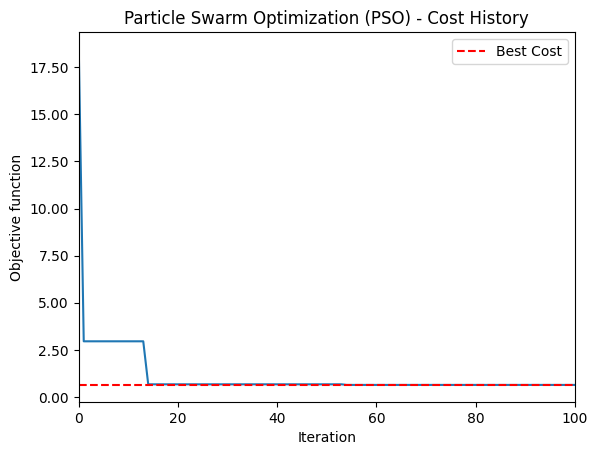

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 63773064.56422952


In [920]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 100000000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcular uma margem de segurança (por exemplo, 10%) com base no valor de best_cost
margin = 3 * best_cost

# Definir os limites do eixo y com base no custo ótimo e na margem
y_min = max(optimal_cost - margin, 0)
y_max = optimal_cost + margin

# Encontre o índice correspondente ao custo ótimo
optimal_cost_index = cost_history.index(optimal_cost)

# Configuração do eixo y
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 100000000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)

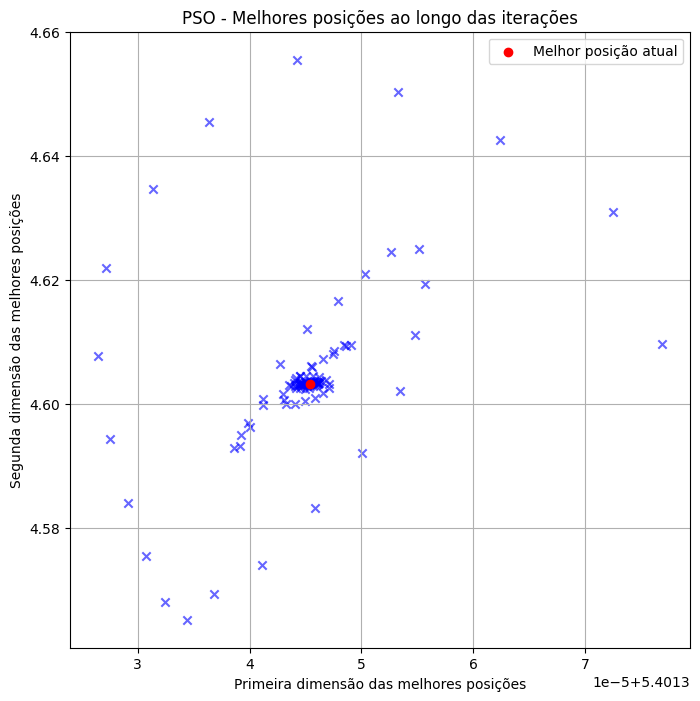

In [921]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [922]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor Custo', 'Lambda (λ)', 'Beta (β)', 'Theta (θ)', 'Número de ciclos de manutenção', 'Tempos para manutenções preventivas', 'Severidade para cada subsistema'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)